In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cd /content/drive/MyDrive/Colab\ Notebooks/cours_python/FSCI2610/projet/Finale

/content/drive/MyDrive/Colab Notebooks/cours_python/FSCI2610/projet/Finale


In [9]:
!pip install neat_python

In [10]:
import pandas as pd

df=pd.read_csv('voice_data.csv')
df.head()
print("Nombre total d'individus:", int(df.Group.count()))
df.Group.unique()

Nombre total d'individus: 108


array(['ASD', 'SLI', 'IC', 'TD'], dtype=object)

In [ ]:
import neat
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("voice_data.csv")

# Filter data to include only 'ASD' and 'CTRL' groups (where CTRL is the combination of 'IC' and 'SLI')
df_filtered = df[(df['Group'] == 'ASD') | (df['Group'] == 'IC') | (df['Group'] == 'SLI')].copy()

# Create a new target variable 'y' with binary labels:
# 0 for 'CTRL' (combined 'IC' and 'SLI') and 1 for 'ASD'
df_filtered['Group_Encoded'] = np.where(df_filtered['Group'] == 'ASD', 1, 0)  # 1 for ASD, 0 for CTRL

y = df_filtered['Group_Encoded'].values
X = df_filtered.loc[:, ["avg_F1", "jitter_s", "shimmer", "mean_hnr"]].values  # Features
net = None
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

le = LabelBinarizer()
y_train = le.fit_transform(y_train) # Fit and transform training labels
y_test = le.transform(y_test) # Transform test labels

# Define the fitness function for NEAT
def evaluate_genome(genomes, config):
    """Evaluate a list of genomes using ROC AUC for binary classification."""
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)

        # Predict on training set (get continuous predictions)
        predictions = []
        for i in range(len(X_train)):
            output = net.activate(X_train[i])
            predictions.append(output[0])  # Use raw output as continuous prediction

        # Reshape predictions to a 2D array with a single column or 1D array
        predictions = np.array(predictions).reshape(-1, 1)

        # Compute ROC AUC and assign fitness
        auc_score = roc_auc_score(y_train, predictions) # Remove multi_class for binary
        genome.fitness = auc_score  # Fitness = ROC AUC score

# NEAT Configuration
def run_neat():
    """Runs NEAT to evolve a neural network for classification."""
    config_path = "neat_config.txt"  # Make sure you have this config file
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)

    # Modify reproduction config to create a new species when extinction occurs
    config.reproduction_config.species_elitism = 0  # Allow extinction
    config.reproduction_config.elitism = 0  # Allow extinction of best individual
    config.reproduction_config.min_species_size = 2  # Minimum species size to avoid extinction

    # Increase population size to promote diversity
    config.pop_size = 60 # Increased from default (usually 150)

    population = neat.Population(config)
    population.add_reporter(neat.StdOutReporter(True))

    # Run NEAT evolution generations
    winner = population.run(evaluate_genome, n=150)

    # Print best genome
    print("Best genome:", winner)

    # Evaluate the best network on test data
    best_net = neat.nn.FeedForwardNetwork.create(winner, config)

    # Get continuous predictions and reshape to 2D or 1D
    predictions = [best_net.activate(x)[0] for x in X_test]
    predictions = np.array(predictions).reshape(-1, 1) # Reshape to 2D

    test_auc = roc_auc_score(y_test, predictions)
    print(f"Final test ROC AUC: {test_auc:.4f}")

    return predictions

# Run NEAT evolution
predictions = run_neat()

# Apply threshold to get binary predictions
predictions_binary = (predictions >= 0.5).astype(int).ravel()

# Calculate and print classification metrics
print("\nClassification report: \n")
print(classification_report(y_test, predictions_binary))

cm = confusion_matrix(y_test, predictions_binary)
print("\nConfusion Matrix: \n")
print(cm)


 ****** Running generation 0 ****** 

Population's average fitness: 0.50111 stdev: 0.15947
Best fitness: 0.91346 - size: (1, 4) - species 1 - id 53
Average adjusted fitness: 0.203
Mean genetic distance 1.380, standard deviation 0.501
Population of 60 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    60      0.5    0.203     0
Total extinctions: 0
Generation time: 0.266 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.59794 stdev: 0.16279
Best fitness: 0.88942 - size: (1, 4) - species 1 - id 64
Average adjusted fitness: 0.302
Mean genetic distance 1.120, standard deviation 0.496
Population of 60 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    60      0.6    0.302     0
Total extinctions: 0
Generation time: 0.140 sec (0.203 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66251 stdev: 0.20

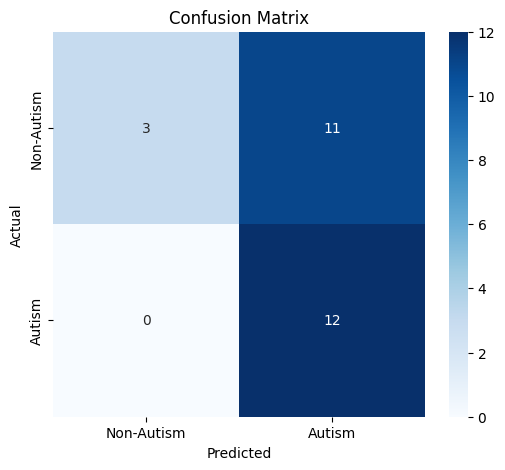

In [ ]:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Autism", "Autism"], yticklabels=["Non-Autism", "Autism"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import pickle

# Save the model to a file
with open("model_nn_neat.pkl", "wb") as f:
    pickle.dump(net, f)